## 0. Set google drive (Important!)

The notebook assumes there is an updated copy of source code available in google drive. The path is proviede below:

In [1]:
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
working_dir = '/content/drive/MyDrive/capstone/BioCV_Su23/src'

os.chdir(working_dir)

Mounted at /content/drive


## 1. Set-up
Install, import, helper functions, including dataloaders and processing functions.


### 1.1 Installation

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets albumentations

# Liveloss plot utility to watch train/validation loss in realtime
!pip install -q livelossplot
!pip install -q onedrivedownloader nibabel google-cloud-storage MedPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

### 1.2 Imports

In [4]:
import os
import random

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision.transforms as transforms

from livelossplot import PlotLosses
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (MaskFormerForInstanceSegmentation,
                          MaskFormerImageProcessor)

#******** TODO: DELETE this part when modules are finalized *********#
# rerun everytime changes are made to the modules
import importlib
import utils.data_handler as dh
import utils.maskformer_dataset as mf_d
import utils.maskformer_evaluation as mf_ev
import utils.maskformer_inference as mf_inf
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics
import utils.mri_common as mri_common

importlib.reload(mf_utils)
importlib.reload(mri_common)
importlib.reload(metrics)
importlib.reload(mf_d)
importlib.reload(dh)
importlib.reload(mf_inf)
importlib.reload(mf_ev)
#******************************************************************#

# local imports
import utils.data_handler as dh
import utils.mri_common as mri_common
import utils.maskformer_utils as mf_utils
import utils.metrics as metrics

from utils.maskformer_dataset import MaskformerMRIDataset, collate_fn
from utils.maskformer_evaluation import MaskFormerEvaluation
from utils.maskformer_inference import MaskFormerInference, get_mask_from_segm_result
from utils.data_handler import DataHandler, MriType

np.set_printoptions(precision=16)

# seeding
torch.manual_seed(100)
np.random.seed(100)
random.seed(100)

data_handler = DataHandler()

### 1.3 Initializations (important!)

In [5]:
# this will dynamically create a new training directory folder with format maskformer/{unix_date}
def create_train_dir_by_date():
  now = str(int( time.time() ))
  return os.path.join("maskformer", now)

In [6]:
brightness_limit = 0.4

# training resolution:
#height, width = 163, 193    #original dimensions
#height, width = 489, 579    #3x
#height, width = 512, 512
# height, width = 652, 772    #4x
#height, width = 815, 965    #5x
#height, width = 897, 1062   #5.5x
#height, width = 978, 1158   #6x

# height, width = 512, 512    # depth 512x512
height, width = 326, 386    # depth
# height, width = 386, 292    # cross_side
# height, width = 326, 292    # cross_front

# direction:
MY_MRI_TYPE_TRAIN = MriType.TRAIN_2D_DEPTH
MY_MRI_TYPE_VAL = MriType.VAL_2D_DEPTH
MY_MRI_TYPE_TEST = MriType.TEST_2D_DEPTH

# MY_MRI_TYPE_TRAIN = MriType.TRAIN_2D_CROSS_SIDE
# MY_MRI_TYPE_VAL = MriType.VAL_2D_CROSS_SIDE

# MY_MRI_TYPE_TRAIN = MriType.TRAIN_2D_CROSS_FRONT
# MY_MRI_TYPE_VAL = MriType.VAL_2D_CROSS_FRONT

# select slice range
n_total = 146 # n_depth
# n_total = 163 # n_cross_side
# n_total = 193  # n_cross_front

# use if we want to use smaller sample starting from the middle slices
slices_mid = 60
file_no_min = n_total//2 - slices_mid
file_no_max = n_total//2 + slices_mid
slices_count = (slices_mid*2) + 1

# training variables:
n_epoch = 40
# mask_weight = 20

# folders
slice_suffix = MY_MRI_TYPE_TRAIN.name.lower().split("2d_")[1]
model_suffix = f"{height}x{width}_{slice_suffix}_slices{slices_count}"
train_dir_prefix = f"maskformer/keith/additive_brightness_40/{model_suffix}"

# load existing model:
model_dir_prefix = f"maskformer/keith/additive_brightness_40/{model_suffix}"
model_file_name = f"model_epoch{n_epoch}.pt"

# variables for calculating metrics
metrics_dir_prefix = f"maskformer/keith/additive_brightness_40/{model_suffix}"
train_metrics_file_name = f"metrics_train.joblib"
val_metrics_file_name = f"metrics_val.joblib"
test_metrics_file_name = "metrics_test.joblib"
RETRAIN = True
LOAD_MODEL = False
RECALCULATE_TRAIN_METRICS = True
RECALCULATE_VAL_METRICS = True
RECALCULATE_TEST_METRICS = True
model_suffix

'326x386_depth_slices121'

In [7]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that train directory
dir_exists = data_handler.dir_exists(train_dir_prefix=train_dir_prefix)
if dir_exists:
  answer = input(f"Chosen train_dir_prefix {train_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new training directory...")
    train_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using training_dir_prefix: {train_dir_prefix}")

Chosen train_dir_prefix maskformer/keith/additive_brightness_40/326x386_depth_slices121 has files stored. 
Are you sure you want to overwrite this folder? Reply YES: y


In [8]:
# this part will check if the directory already exists and whether the person intends to overwrite the files in that metrics directory
dir_exists = data_handler.dir_exists(train_dir_prefix=metrics_dir_prefix)
if dir_exists:
  answer = input(f"Chosen metrics_dir_prefix {metrics_dir_prefix} has files stored. \nAre you sure you want to overwrite this folder? Reply YES: ")
  if answer.lower() not in ["yes", "y"]:
    print("Dynamically creating a new metrics directory...")
    metrics_dir_prefix = create_train_dir_by_date()

print(f"\nFiles will be saved using metrics_dir_prefix: {metrics_dir_prefix}")

Chosen metrics_dir_prefix maskformer/keith/additive_brightness_40/326x386_depth_slices121 has files stored. 
Are you sure you want to overwrite this folder? Reply YES: y

Files will be saved using metrics_dir_prefix: maskformer/keith/additive_brightness_40/326x386_depth_slices121



## 2. Process 2D data

### 2.0 Initialize parameters

### 2.1 Load and select data

In [9]:
# initialize filenames for saving entire dataset. suffix will give the slice direction
suffix = MY_MRI_TYPE_TRAIN.name.lower().split("2d_")[1]

train_list_full = f"data_train_all_{suffix}.txt"
val_list_full   = f"data_val_all_{suffix}.txt"

# list all files from the directory
train_2d = data_handler.list_mri_in_dir(mri_type=MY_MRI_TYPE_TRAIN)
val_2d = data_handler.list_mri_in_dir(mri_type=MY_MRI_TYPE_VAL)

# save the list in another file only if they don't exist yet
train_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = train_list_full)
if not train_file_exists:
    data_handler.save_text(file_name = train_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in train_2d))

val_file_exists = data_handler.file_exists(train_dir_prefix=train_dir_prefix, file_name = val_list_full)
if not val_file_exists:
    data_handler.save_text(file_name = val_list_full,
                        train_dir_prefix=train_dir_prefix,
                        data='\n'.join(str(item) for item in val_2d))


train_list_full, val_list_full

('data_train_all_depth.txt', 'data_val_all_depth.txt')

#### Using a small portion of data for efficient testing

In [10]:
# initialize filenames for saving a smaller sample
train_list = f"data_train_{suffix}.txt"
val_list   = f"data_val_{suffix}.txt"

# if we want to use all slices
# file_no_min = 0
# file_no_max = n_total + 1

# select patent id range. 0 to 88 for entire range
subj_total = 88
subj_id_min = 0
subj_id_max = subj_total + 1

# define train and validation
# TODO: can we delete this code and just use train_2d and val_2d directly?
# subj_train_files = data_handler.load_text_as_list(file_name=train_list_full,
#                                                   train_dir_prefix=train_dir_prefix)
# subj_val_files = data_handler.load_text_as_list(file_name=val_list_full,
#                                                 train_dir_prefix=train_dir_prefix)

# obtain subset of training files
train_data_list = mf_utils.get_subset_files(train_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = train_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in train_data_list))

print(f"Number of unique training samples: {len(train_data_list)}")


# obtain subset of validation files
val_data_list = mf_utils.get_subset_files(val_2d, file_no_min, file_no_max, subj_id_min, subj_id_max)
data_handler.save_text(file_name = val_list,
                       train_dir_prefix=train_dir_prefix,
                       data='\n'.join(str(item) for item in val_data_list))
print(f"Number of unique validation samples: {len(val_data_list)}")

print("filename for smaller sample:", train_list, val_list)

Number of unique training samples: 10560
Number of unique validation samples: 3600
filename for smaller sample: data_train_depth.txt data_val_depth.txt


### 2.2 Create Custom PyTorch Dataset


In [11]:
# set maskformer processor
# set do_reduce_label to False. Otherwise, problem with no-labeled data (ignored and causes mismatch of indices)
# processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)
processor = MaskFormerImageProcessor(do_reduce_labels=False, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [12]:
# load sample list from text file saved from 2.1
# TODO: again, confirm if loading from text file is still needed
train_data_list = data_handler.load_text_as_list(file_name = train_list, train_dir_prefix=train_dir_prefix)
val_data_list = data_handler.load_text_as_list(file_name = val_list, train_dir_prefix=train_dir_prefix)

# Get the first file name from the train_data_list
orig_dim = data_handler.load_mri(subj_id=train_data_list[0].split('_')[0], mri_type=MY_MRI_TYPE_TRAIN,
                                 file_no=int(train_data_list[0].split('_')[1].split('.')[0])).shape

# define data transforms
train_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
    A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=0, brightness_by_max=True)
])

# create datasets
train_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_TRAIN, data_list=train_data_list, processor=processor, transform=train_transform, augment=True)
val_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_VAL, data_list=val_data_list, processor=processor, transform=train_transform, augment=False)

# setup data loader
# batch_size = 2 # for the 512x512
batch_size = 16 # for the 2x resolition cases

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

### 2.3 QC dataset

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([1, 326, 386])
class_labels torch.Size([1])
10560
tensor([0])


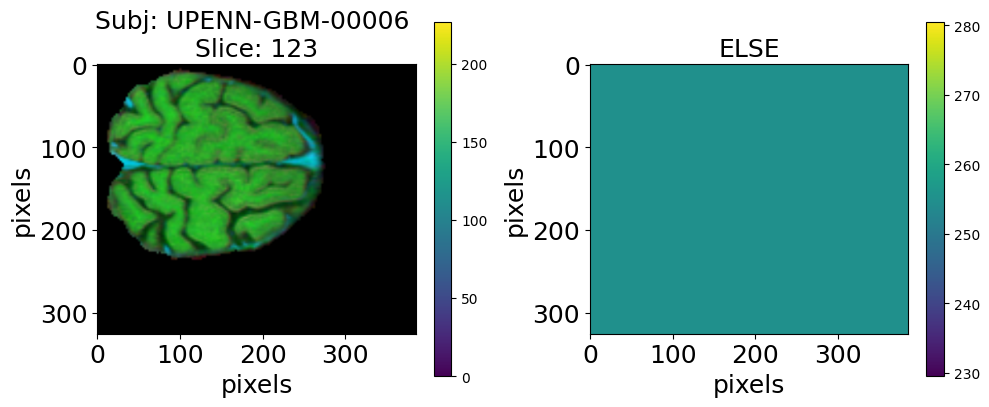

In [13]:
# peek at the train dataset
#rand_test = random.randint(0, len(train_dataset))
train_input = train_dataset[110]
for k,v in train_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(train_dataset))
print(train_input["class_labels"])

train_img_title = f"Subj: {train_input['subj_no']} \nSlice: {train_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=train_input["class_labels"].tolist(),
             pixel_values = train_input['pixel_values'].numpy(),
             mask_labels = train_input['mask_labels'],
             title = train_img_title)

pixel_values torch.Size([3, 326, 386])
pixel_mask torch.Size([326, 386])
mask_labels torch.Size([1, 326, 386])
class_labels torch.Size([1])
3600
tensor([0])


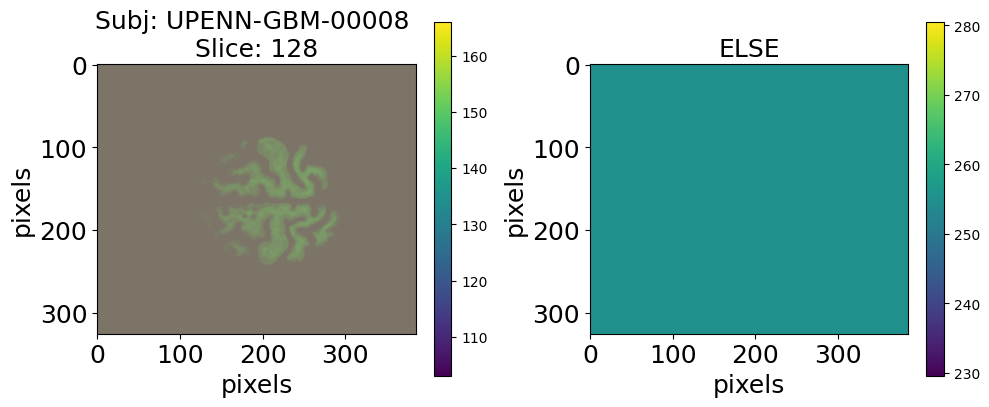

In [14]:
# peek at the val dataset
#rand_test = random.randint(0, len(val_dataset))
val_input = val_dataset[115]
for k,v in val_input.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)

print(len(val_dataset))
print(val_input["class_labels"])

# plot val dataset
val_img_title = f"Subj: {val_input['subj_no']} \nSlice: {val_input['file_no']}"
mf_utils.plot_mask_labels(class_labels=val_input["class_labels"].tolist(),
             pixel_values = val_input['pixel_values'].numpy(),
             mask_labels = val_input['mask_labels'],
             title= val_img_title)

## 3. Fine-tuning Model

### 3.1 Define the model

In [15]:
# Make label dictionary
id2label = mri_common.SEGMENTS.copy()
print(id2label)

label2id = {}
for key, value in id2label.items():
    label2id[value] = key
print(label2id)

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained maskformer model
# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-small-ade",
                                                          id2label=id2label,
                                                          label2id=label2id,
                                                          ignore_mismatched_sizes=True)

# based model only used for the 512x512 case
# model = MaskFormerForInstanceSegmentation.from_pretrained("zuppif/maskformer-swin-base-ade",
#                                                           id2label=id2label,
#                                                           label2id=label2id,
#                                                           ignore_mismatched_sizes=True)

{0: 'ELSE', 1: 'NCR', 2: 'ED', 3: 'ET'}
{'ELSE': 0, 'NCR': 1, 'ED': 2, 'ET': 3}


Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at zuppif/maskformer-swin-small-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# load saved model if needed
if LOAD_MODEL == True:
    model = data_handler.load_torch_model(file_name=model_file_name, train_dir_prefix=model_dir_prefix, device=device)
else:
    # model.config.mask_weight  = mask_weight
    pass

In [17]:
# add outputs
# model.config.decoder_config.output_attentions = True
# model.config.decoder_config.output_hidden_states = True
# model.config.decoder_config.output_scores = True
model.config.output_attentions = True
# model.config.output_hidden_states = True

# reset weight of losses
# model.config.mask_weight  = 2.0
# model.config.dice_weight = 0.1
# model.config.cross_entropy_weight  = 10000.0
# model.config.use_auxiliary_loss = False
# model.config.ce_weight = 10000.0

# print model config
configuration = model.config
print(configuration)

MaskFormerConfig {
  "_commit_hash": "f4097ad31123b84e35d4f9e977f746fa703c12ab",
  "_name_or_path": "zuppif/maskformer-swin-small-ade",
  "architectures": [
    "MaskFormerForInstanceSegmentation"
  ],
  "backbone_config": {
    "_name_or_path": "",
    "add_cross_attention": false,
    "architectures": null,
    "attention_probs_dropout_prob": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "depths": [
      2,
      2,
      18,
      2
    ],
    "diversity_penalty": 0.0,
    "do_sample": false,
    "drop_path_rate": 0.3,
    "early_stopping": false,
    "embed_dim": 96,
    "encoder_no_repeat_ngram_size": 0,
    "encoder_stride": 32,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
 

In [18]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(batch_size, 3, width, height), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                                         Input Shape          Output Shape         Param #              Trainable
MaskFormerForInstanceSegmentation (MaskFormerForInstanceSegmentation)                           [16, 3, 386, 326]    [16, 8, 100, 100]    --                   True
├─MaskFormerModel (model)                                                                       [16, 3, 386, 326]    [16, 8, 100, 100]    --                   True
│    └─MaskFormerPixelLevelModule (pixel_level_module)                                          [16, 3, 386, 326]    --                   --                   True
│    │    └─MaskFormerSwinBackbone (encoder)                                                    [16, 3, 386, 326]    [16, 96, 97, 82]     48,840,138           True
│    │    └─MaskFormerPixelDecoder (decoder)                                                    [16, 96, 97, 82]     --                   4,304,640            True
│    └─Mask

The warning is telling us that we're throwing away the classification head and randomly initializing a new one.

### 3.2 Calculate initial loss

Let's take the first batch of the training dataset and forward it through the model, see if we get a loss that makes sense.

This is another trick from [this amazing blog post](http://karpathy.github.io/2019/04/25/recipe/) if you wanna debug your neural networks.

In [19]:
# # obtain a batch of data
# batch = next(iter(train_dataloader))

# model.to(device)

# outputs = model(
#         pixel_values=batch["pixel_values"].to(device),
#         mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
#         class_labels=[labels.to(device) for labels in batch["class_labels"]],
#       )
# loss_init = outputs.loss.item()

# # print basic info
# for k,v in batch.items():
#   if isinstance(v, torch.Tensor):
#     print(k,v.shape)
#   else:
#     print(k,len(v))

# # print some info
# print([label.shape for label in batch["class_labels"]])
# print([label.shape for label in batch["mask_labels"]])

# # print loss
# print('Initial Loss is:', loss_init)


### 3.3 Train the model

In [23]:
# TODO: move this to a train function and parameterize hyperparameters

if RETRAIN:

    liveloss = PlotLosses()

    batch_max = 100000
    loss_train = []
    loss_val = []
    min_loss = 1e9
    # mutiplier is used to scale loss values to be more readable
    loss_multiplier = 10.0

    # saving model half way
    SAVE_INT = n_epoch // 2

    # define learning rate
    # lr = 2e-5
    lr = 1e-5
    # lr = 0.5e-5

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # print( 'Initial loss is {:10.6f}.'.format(round(loss_init, 6)*loss_multiplier) )
    logs = {}
    # logs['loss'] = loss_init
    # logs['val_loss'] = loss_init

    # liveloss.update(logs)
    # liveloss.send()

    for epoch in range(1, n_epoch+1):
        print("Starting Epoch:", epoch)

        ## training loop
        running_loss = 0.0
        num_samples = 0
        model.train()
        for ibatch, batch in enumerate(tqdm(train_dataloader)):
            # run partial data based on input limit
            if ibatch < batch_max:
                # Reset the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(
                        pixel_values=batch["pixel_values"].to(device),
                        mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                        class_labels=[labels.to(device) for labels in batch["class_labels"]],
                )

                # Backward propagation
                loss = outputs.loss * loss_multiplier
                loss.backward()

                batch_size = batch["pixel_values"].size(0)
                running_loss += loss.item()
                num_samples += batch_size
                loss_train_cur = running_loss/num_samples

                # Optimization
                optimizer.step()
            else:
                # skip where ibatch >= batch_max
                break

        # record loss at the end of each epoch
        logs['loss'] = loss_train_cur
        print( 'Epoch {:<4} training loss is: {:8.6f}.'.format(epoch, round(loss_train_cur, 6)) )
        loss_train.append(loss_train_cur)

        ## validation loop
        running_loss = 0.0
        num_samples = 0
        model.eval()
        with torch.no_grad():
            for ibatch, batch in enumerate(tqdm(val_dataloader)):
                # run partial data based on input limit
                if ibatch < batch_max:
                    # Forward pass
                    outputs = model(
                            pixel_values=batch["pixel_values"].to(device),
                            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                            class_labels=[labels.to(device) for labels in batch["class_labels"]],
                    )

                    # loss
                    loss = outputs.loss  * loss_multiplier

                    batch_size = batch["pixel_values"].size(0)
                    running_loss += loss.item()
                    num_samples += batch_size
                    loss_val_cur = running_loss/num_samples
                else:
                    # skip where ibatch >= batch_max
                    break

        # record loss at the end of each epoch
        logs['val_loss'] = loss_val_cur
        # print( 'Epoch {:<4} validation loss is: {:8.6f}.'.format(epoch, round(loss_val_cur, 6)) )
        loss_val.append(loss_val_cur)

        # if found better model, update min_loss and save model (currently using training loss)

        if min_loss > loss_val_cur:
            print("Saved model in epoch",epoch)
            # save the best model
            # data_handler.save_torch_model(file_name="model_current.pt", train_dir_prefix=train_dir_prefix, model=model)
            min_loss = loss_val_cur

        # save model regularly
        if epoch%SAVE_INT == 0:
            print("Saved model in epoch",epoch)

            # save the best model
            data_handler.save_torch_model(file_name=f'model_epoch'+str(epoch)+'.pt', train_dir_prefix=train_dir_prefix, model=model)

        # Update the plot with new logging information.
        liveloss.update(logs)
        liveloss.send()

    # save loss at the end
    data_handler.save_torch_model(file_name='losses_train_current.pt', train_dir_prefix=train_dir_prefix, model=loss_train)
    data_handler.save_torch_model(file_name='losses_val_current.pt', train_dir_prefix=train_dir_prefix, model=loss_val)

Starting Epoch: 1


  0%|          | 0/660 [00:00<?, ?it/s]

OutOfMemoryError: ignored

## 4. Evaluation

### 4.1 Make prediction on one sample

#### 4.1.1 Model prediction and visualization on one sample

In [ ]:
# define a transform without resizing
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
    A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=0, brightness_by_max=True)
])

# create a test data loader without shuffling
QC_TYPE = 'val'

# fixed batch size for now
batch_size = 10
if QC_TYPE == 'train':

    # uses the same transformation during training
    qc_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_TRAIN, data_list=train_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
else:
    # uses the same transformation during training
    qc_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # new dataloader without resized image
    org_dataset = MaskformerMRIDataset(data_handler=data_handler, data_identifier=MY_MRI_TYPE_VAL, data_list=val_data_list, processor=processor, transform=org_transform, augment=False)
    org_dataloader = DataLoader(org_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [ ]:
# TO QC a specific subj: UPENN-GBM-00131 and file number
target_subj = "UPENN-GBM-00008"

# find the index/indices in val_data_list corresponding to the 2d slices for the specified patient
subj_indices = [index for index, file_name in enumerate(val_data_list) if target_subj in file_name]

# specify which slice/file_no
test_file_no = 80

# get relative index of test_file_no
target_file_no = subj_indices[0] + test_file_no
target_batch = int(target_file_no//batch_size)
test_idx = target_file_no%batch_size
print("target batch", target_batch)
print("test idx", test_idx)

In [ ]:
# obtain targeted batch of data. note that we used batch_size = 1
# therefore, batch index is the same as the file index from our datalist
# also, the loader will be slow if we have a large index.

# we can override target_batch and test_idx if testing randomly
# target_batch = 10
# test_idx = 0

for ibatch, batch in enumerate(qc_dataloader):
    if ibatch == target_batch:
        test_batch = batch
        break
    else:
        continue

for k,v in test_batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)
  else:
    print(k, len(v))

test_image =  test_batch["pixel_values"][test_idx]
test_pixel_mask = test_batch["pixel_mask"][test_idx]
test_mask_labels = test_batch["mask_labels"][test_idx]
test_class_labels = test_batch["class_labels"][test_idx]
test_subj = test_batch["subj_no"][test_idx] + "_" +  test_batch["file_no"][test_idx]
print(test_subj)

In [ ]:
# prepare transform to use for inferencing. should be the same as train_transform
predict_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
    A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=0, brightness_by_max=True)
])

# MaskFormerInference will take care of prediction but batch size for now is fixed to 1
test_mf_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_VAL,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)

# outputs = model output
# result = this is the method that runs MaskFormer post_process_semantic_segmentation
outputs, batch_results = test_mf_inference.predict_segm(test_batch, batch_size=batch_size)

# use test_idx to get results from batch
results = batch_results[test_idx]

for segment_info in results['segments_info']:
    print(segment_info)
print("segmentation result shape", results['segmentation'].shape)
print("segmentation unique values", np.unique( results['segmentation']))

In [ ]:
# Obtain labels in true, predict, intersection and union
labels_true = []
for label in test_class_labels.numpy():
    labels_true.append( id2label[label] )

labels_pred = []
for segment in results['segments_info']:
    labels_pred.append( id2label[segment['label_id']] )

# remove duplicates
labels_pred = list(set(labels_pred))
labels_all = list(set(labels_true) | set(labels_pred))
labels_common = list(set(labels_true) & set(labels_pred))

# QC all true and predicted categories
print("True labels:",labels_true)
print("Predicted labels:",labels_pred)
print("All labels:", labels_all)
print("Common labels:",labels_common)

In [ ]:
# QC predicted masks with segmentation with Maskformer resolution

# this will convert post_process_semantic_segmentation to masks so the format is similar with the maskformer input
pred_mask_labels, pred_class_labels = get_mask_from_segm_result(segm_result=results)
input_class_labels = test_class_labels.numpy()

# the conversion will allow us to compare the two side by side
mf_utils.plot_mask_labels(class_labels= input_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = test_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = test_image.numpy(),
             mask_labels = pred_mask_labels,
             title= test_subj + " Prediction")


In [ ]:
# plot predicted segment over of input segment.
# note: if a segment is predicted but does not exist in the input mask, it will not show here

mf_utils.plot_mask_comparison(input_class_labels=input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=test_image.numpy(),
                     input_mask_labels=test_mask_labels,
                     pred_mask_labels=pred_mask_labels,
                     title=test_subj)


In [ ]:
# mask_to_segmentation will flatten mask labels with shape  (n_label, width, height) to a segmentation image (width, height)
input_segmentation = mf_utils.mask_to_segmentation(mask_labels=test_mask_labels, class_labels=input_class_labels)
pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels, class_labels=pred_class_labels)

mf_utils.plot_segmentation_comparison(
        input_pixel_values=test_image.numpy(),
        input_segmentation=input_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")

#### 4.1.2 Calculate metrics on predicted sample

In [ ]:
# review dimensions and predicitios
all_labels = list(id2label.keys())
print("all segments:", all_labels)

print("\nlabels:")
input_class_labels = list(test_class_labels.numpy())
print("input_class_labels", input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape", test_mask_labels.shape)
print("pred_mask shape", pred_mask_labels.shape)
print("note that dimension changes based on the number of labels")


In [ ]:
mask_shape = pred_mask_labels[0, :, :].shape

# loop through segments 0 to 3
for label_id in all_labels:

    print(f"Metrics for {label_id} - {id2label[label_id]}:")
    pred_mask = np.zeros(mask_shape, dtype=np.uint8)
    true_mask = np.zeros(mask_shape, dtype=np.uint8)

    if label_id in input_class_labels:
        # extract layer in test_mask_labels corresponding to the label
        true_mask_idx = input_class_labels.index(label_id)
        true_mask = test_mask_labels[true_mask_idx, :, :].numpy().squeeze().astype(np.uint8)

    if label_id in pred_class_labels:
        # extract layer in pred_mask_labels corresponding to the label
        pred_mask_idx = pred_class_labels.index(label_id)
        pred_scaled_mask = pred_mask_labels[pred_mask_idx, :, :].squeeze()
        pred_mask = mf_utils.descale_mask(pred_scaled_mask)

    # calculate metrics
    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)
    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])
    print()

#### 4.1.3 Visualize model output

In [ ]:
input_image = test_image.permute(1,2,0).numpy()
plt.imshow(input_image)
plt.show()

In [ ]:
# print information on the output
print('output keys:',outputs.keys())

print('class_queries_logits shape:',outputs.class_queries_logits.shape)
print('masks_queries_logits shape:',outputs.masks_queries_logits.shape)

print('encoder_last_hidden_state shape:',outputs.encoder_last_hidden_state.shape)
print('pixel_decoder_last_hidden_state shape:',outputs.pixel_decoder_last_hidden_state.shape)
print('transformer_decoder_last_hidden_state shape:',outputs.transformer_decoder_last_hidden_state.shape)

print('len(attentions):',len(outputs.attentions))
print('attentions[0]:',outputs.attentions[0].shape)


In [ ]:
# visualize the last layer of the encoder
n_row = 16
n_col = 16
n_skip = 2

fig, axs = plt.subplots(nrows=n_row//n_skip, ncols=n_col//n_skip,
                        figsize=(n_col//n_skip, n_row//n_skip))

for irow in range(n_row//n_skip):
    for icol in range(n_col//n_skip):
        idx = (irow*n_skip) * n_col + icol*n_skip
        encoder_last_hidden_state = outputs.encoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('encoder output')
fig.tight_layout()
fig.show()

In [ ]:
# visualize the last layer of the pixel decodeer
n_row = 16
n_col = 16

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow * n_col + icol
        encoder_last_hidden_state = outputs.pixel_decoder_last_hidden_state[0,idx,:,:].detach().cpu().numpy()
        axs[irow,icol].imshow(encoder_last_hidden_state)
        axs[irow,icol].axis('off')

fig.suptitle('pixel_decoder output')
fig.tight_layout()
plt.show()

In [ ]:
# visualize the attention map
n_row = 6
n_col = 8

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col, n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        attention_test = outputs.attentions[irow][0,icol,:,:].squeeze().detach().cpu().numpy()
        axs[irow,icol].imshow(attention_test)
        axs[irow,icol].axis('off')

fig.tight_layout()
fig.show()

In [ ]:
# compute and visualize class probability prediction

n_row = 10
n_col = 10

class_probs = np.zeros((outputs.class_queries_logits.shape[1], outputs.class_queries_logits.shape[2]))

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol
        class_queries_logits_test = outputs.class_queries_logits[0,idx,:].squeeze().detach().cpu().numpy()

        class_probs[idx,:] = mf_utils.softmax(class_queries_logits_test)

        axs[irow,icol].plot(class_probs[idx,:])
        # axs[irow,icol].axis('off')

fig.suptitle('Class probability')
fig.tight_layout()
fig.show()

In [ ]:
# compute mask prediction from pixel decoder and transofmrer decoder
# it is a dot product reducing the channel dimmension followed by a sigmoind activation
img_width = outputs.pixel_decoder_last_hidden_state.shape[-1]
img_height = outputs.pixel_decoder_last_hidden_state.shape[-2]

# Reshape array1 for matrix multiplication
pixel_decoder_reshaped = outputs.pixel_decoder_last_hidden_state[0,:,:,:].squeeze().detach().cpu().reshape(256, img_width*img_height)
transformer_decoder_reshaped = outputs.transformer_decoder_last_hidden_state[0,:,:].squeeze().detach().cpu().reshape(100, 256)

# Perform matrix multiplication
mask_pred_vis = torch.matmul(transformer_decoder_reshaped, pixel_decoder_reshaped)

# Apply sigmoid function
mask_pred_vis = torch.sigmoid(mask_pred_vis)

# Reshape result to the desired shape
mask_pred_vis = mask_pred_vis.reshape(100, img_height, img_width).numpy()

mask_pred_vis.shape

In [ ]:
print(pixel_decoder_reshaped.shape)
print(transformer_decoder_reshaped.shape)

In [ ]:
# visualize mask prediction
n_row = 10
n_col = 10

fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(3*n_col, 3*n_row))  # Create subplots grid

for irow in range(n_row):
    for icol in range(n_col):
        idx = irow*n_col+icol

        img = axs[irow,icol].imshow(mask_pred_vis[idx,:,:])
        axs[irow,icol].axis('off')
        fig.colorbar(img, ax=axs[irow,icol])

fig.suptitle('Mask pred')
fig.tight_layout()
fig.show()


In [ ]:
# Reshape array1 for matrix multiplication
class_probs_tensor = torch.from_numpy(class_probs).double()
mask_pred_tensor = torch.from_numpy(mask_pred_vis).double()

matrix1 = class_probs_tensor.permute(1, 0)
matrix2 = mask_pred_tensor.reshape(100, img_width*img_height)

matrix_out = torch.matmul(matrix1, matrix2).reshape(5,img_height,img_width)

result = torch.argmax(matrix_out[:-1,:,:], dim=0)

print(result.shape)

plt.imshow(result)
plt.colorbar()
plt.show()

#### 4.1.4 QC Resized Transform

In [ ]:
# previous target batch
target_batch

In [ ]:
# obtain one batch of original data
# org_dataloader is the dataloader which has the original size of the image
for ibatch, batch in enumerate(org_dataloader):
    if ibatch == target_batch:
        org_batch = batch
        break
    else:
        continue

org_image =  org_batch["pixel_values"][test_idx]
org_pixel_mask = org_batch["pixel_mask"][test_idx]
org_mask_labels = org_batch["mask_labels"][test_idx]
org_class_labels = org_batch["class_labels"][test_idx]
org_subj = org_batch["subj_no"][test_idx] + "_" +  org_batch["file_no"][test_idx]
print(org_subj)

In [ ]:
# resize predicted mask from 4.1.1 to original size
# re-run code from 4.1.1 (expected same output. just rewriting for readability/accessibility)
pred_mask_labels, pred_class_labels = get_mask_from_segm_result(segm_result=results)
pred_mask_labels_rs = mf_utils.resize_mask(pred_mask_labels, orig_dim)

# plot input mask labels
org_input_class_labels = org_class_labels.numpy()
mf_utils.plot_mask_labels(class_labels= org_input_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = org_mask_labels,
             title= test_subj + " Input")

# plot predicted mask labels
mf_utils.plot_mask_labels(class_labels=pred_class_labels,
             pixel_values = org_image.numpy(),
             mask_labels = pred_mask_labels_rs,
             title= test_subj + " Prediction")

mf_utils.plot_mask_comparison(input_class_labels=org_input_class_labels,
                     pred_class_labels=pred_class_labels,
                     input_pixel_values=org_image.numpy(),
                     input_mask_labels=org_mask_labels,
                     pred_mask_labels=pred_mask_labels_rs,
                     title=test_subj)


In [ ]:
# or maybe used actual file
org_subj_id = org_batch["subj_no"][0]
org_file_id = org_batch["file_no"][0]

# compare to actual file
org_segmentation = data_handler.load_mri("UPENN-GBM-00008", mri_type=MY_MRI_TYPE_VAL, file_no=80)

# this is the input mask from MaskFormer. confirmed to have the same segments as the actual file
# org_segmentation = mf_utils.mask_to_segmentation(mask_labels=org_mask_labels, class_labels=org_input_class_labels)

pred_segmentation = mf_utils.mask_to_segmentation(mask_labels=pred_mask_labels_rs, class_labels=pred_class_labels)

print("orig segmentation shape", org_segmentation.shape)
print("pred segmentation shape", pred_segmentation.shape)

In [ ]:
# plot the 2 segmentations
mf_utils.plot_segmentation_comparison(
        input_pixel_values=org_image.numpy(),
        input_segmentation=org_segmentation,
        pred_segmentation=pred_segmentation,
        title=test_subj,
        loc="upper left")

#### 4.1.5 Calculate metrics on resized sample

In [ ]:
# review dimensions and predictions
print("\nlabels:")
org_input_class_labels = list(org_class_labels.numpy())
print("org_class_labels", org_input_class_labels)
print("pred_class_labels", pred_class_labels)

print("\nsegmentation shapes:")
print("true_mask shape (orig size)", org_mask_labels.shape)
print("pred_mask shape (resized to orig)", pred_mask_labels_rs.shape)
print("note that dimension changes based on the number of labels")

In [ ]:
mask_shape = pred_mask_labels_rs[0, :, :].shape

# loop through segments 0 to 3
for label_id in all_labels:

    print(f"Metrics for {label_id} - {id2label[label_id]}:")
    pred_mask = np.zeros(mask_shape, dtype=np.uint8)
    true_mask = np.zeros(mask_shape, dtype=np.uint8)

    if label_id in org_input_class_labels:
        # extract layer corresponding to the label
        true_mask_idx = org_input_class_labels.index(label_id)
        true_mask = org_mask_labels[true_mask_idx, :, :].numpy().squeeze().astype(np.uint8)

    if label_id in pred_class_labels:
        # get which layer/index corresponds to the label
        pred_mask_idx = pred_class_labels.index(label_id)
        pred_scaled_mask = pred_mask_labels_rs[pred_mask_idx, :, :].squeeze()
        pred_mask = mf_utils.descale_mask(pred_scaled_mask)

    dice_score = metrics.calc_dice_score(pred_mask, true_mask)
    print("Dice Score", dice_score)

    hd95 = metrics.calc_hausdorff_95(pred_mask, true_mask)
    print("HD95", hd95)

    other_metrics = metrics.calc_binary_metrics(pred_mask, true_mask)
    print("Specificity", other_metrics["specificity"])
    print("Sensitivity", other_metrics["sensitivity"])
    print("Precision", other_metrics["precision"])
    print("Recall", other_metrics["recall"])
    print()

### 4.2 Make predictions on all data and compute metrics

#### 4.2.0 Initialize variables

In [ ]:
# prepare inference class to perform prediction

# ORIGINAL EVALUATION
# define a transform for upscaled predictions
predict_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
    A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=0, brightness_by_max=True)
])


mf_val_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_VAL,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)
print("total validation files", len(mf_val_inference.all_files))

mf_train_inference=MaskFormerInference(data_handler=data_handler,
                                     data_identifier=MY_MRI_TYPE_TRAIN,
                                     model=model,
                                     processor=processor,
                                     upscaled_transform=predict_transform,
                                     scale_to_orig_size=False)

print("total training files", len(mf_train_inference.all_files))

In [ ]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
org_transform = A.Compose([
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
    A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=0, brightness_by_max=True)
])

predict_transform = A.Compose([
    A.Resize(width=width, height=height),
    A.Normalize(mean=mf_utils.ADE_MEAN, std=mf_utils.ADE_STD),
    A.RandomBrightnessContrast(brightness_limit=brightness_limit, contrast_limit=0, brightness_by_max=True)
])

mf_eval=MaskFormerEvaluation()

# note: scale_to_orig_size is True by default since this is what will be using moving forward.
# Im just making it explicit here
mf_val_inference_upscaled=MaskFormerInference(data_handler=data_handler,
                                              data_identifier=MY_MRI_TYPE_VAL,
                                              model=model,
                                              processor=processor,
                                              upscaled_transform=predict_transform,
                                              orig_transform=org_transform,
                                              scale_to_orig_size=True,
                                              orig_dim=orig_dim)

print("total validation files", len(mf_val_inference.all_files))

mf_test_inference_upscaled=MaskFormerInference(data_handler=data_handler,
                                            data_identifier=MY_MRI_TYPE_TEST,
                                            model=model,
                                            processor=processor,
                                            upscaled_transform=predict_transform,
                                            orig_transform=org_transform,
                                            scale_to_orig_size=True,
                                            orig_dim=orig_dim)

print("total test files", len(mf_train_inference.all_files))

#### 4.2.3 Put the metrics side by side

TODO: do further investigation here

#### 4.2.4  Obtain Validation datalist

In [ ]:
# Obtain all validation subjects
val_subjs = mf_utils.get_all_subj_ids(data_handler=data_handler, mri_type=MY_MRI_TYPE_VAL)
print("total validation data", len(val_subjs))
print("first 5 validation subjects")
val_subjs[:5]

#### 4.2.5 Calculate Metrics for Validation Data

In [ ]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
print("val metrics_file_name: ", "upscaled_"+val_metrics_file_name)
val_metrics_dict_upscaled, val_error_files_upscaled, val_success_files_upscaled = mf_eval.predict_and_eval(subj_names=val_subjs,
                                                                                data_handler=data_handler,
                                                                                mf_inference=mf_val_inference_upscaled,
                                                                                metrics_dir_prefix=metrics_dir_prefix,
                                                                                metrics_file_name="upscaled_"+val_metrics_file_name,
                                                                                recalculate=RECALCULATE_VAL_METRICS)

#### 4.2.6 Evaluate Validation Data

##### Summary statistics

In [ ]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
mf_eval.display_statistics(val_metrics_dict_upscaled)

Final report metric summary

In [ ]:
val_mean_scores_upscaled = mf_eval.get_mean_scores(val_metrics_dict_upscaled)
val_mean_scores_upscaled

Box plots

In [ ]:
mf_eval.draw_box_plots(val_metrics_dict_upscaled)

TEST DATASET

In [ ]:
# Obtain all validation subjects
test_subjs = mf_utils.get_all_subj_ids(data_handler=data_handler, mri_type=MY_MRI_TYPE_TEST)
print("total test data", len(test_subjs))
print("first 5 test subjects")
test_subjs[:5]

In [ ]:
# UPDATED EVALUATION, downscales predicted masks, compares to original dimension masks
# results in 2-4% decrease in precision/dice!
print("val metrics_file_name: ", "upscaled_"+val_metrics_file_name)
test_metrics_dict_upscaled, test_error_files_upscaled, test_success_files_upscaled = mf_eval.predict_and_eval(subj_names=test_subjs,
                                                                                data_handler=data_handler,
                                                                                mf_inference=mf_test_inference_upscaled,
                                                                                metrics_dir_prefix=metrics_dir_prefix,
                                                                                metrics_file_name="upscaled_"+test_metrics_file_name,
                                                                                recalculate=RECALCULATE_TEST_METRICS)

In [ ]:
test_mean_scores_upscaled = mf_eval.get_mean_scores(test_metrics_dict_upscaled)
test_mean_scores_upscaled

In [ ]:
mf_eval.draw_box_plots(test_metrics_dict_upscaled)

In [ ]:
mf_eval.build_histogram(test_metrics_dict_upscaled)